It is begun with importing essential libraries needed for data manipulation, model building, evaluation, and visualization.

In [4]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

The dataset is loaded and preprocessed to handle missing values and ensure it's in the correct format for modeling.

In [6]:
#Load and preprocess dataset
df = pd.read_csv("data_3dprinter.csv")
df.rename(columns={"tension_strenght": "tensile_strength"}, inplace=True)

#Encode categorical features
if 'infill_pattern' in df.columns:
    df['infill_pattern'] = df['infill_pattern'].map({'grid': 0, 'honeycomb': 1})
if 'material' in df.columns:
    df['material'] = df['material'].map({'abs': 0, 'pla': 1})
df.drop(columns=['material', 'infill_pattern'], errors='ignore', inplace=True)

Dataset is splitted into input features and the target variable, which is surface roughness in this case.

Now that the model is trained, can proceed to evaluate its performance using defined metrics.

In [9]:
#Feature and target definition
X = df.drop(columns=['roughness'])
y = df['roughness']

Different values for `max_depth` and `random_state` were tested using a grid search approach to find the best model parameters.

The scatter plot helps us visually inspect how close our predictions are to the actual values.

In [11]:
#Grid search over max_depth & random_state
results = []
for max_depth in range(1, 101):
    for random_state in range(101):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        model = DecisionTreeRegressor(max_depth=max_depth)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2 = r2_score(y_test, y_test_pred)
        results.append((max_depth, random_state, rmse, r2))

#Results dataframe
results_df = pd.DataFrame(results, columns=['MaxDepth', 'RandomState', 'RMSE', 'R2'])
best_model = results_df.loc[results_df['RMSE'].idxmin()]
print("\n Best Model Found:")
print(best_model)


 Best Model Found:
MaxDepth       19.000000
RandomState    10.000000
RMSE           13.758634
R2              0.985373
Name: 1828, dtype: float64


Helps to find the best Hyperparameters to be used in the model including random state, depth and the expected correlation. This is done to ensure the best fit of the model for the specific target. The best random state here was found as 10, but the best maxDepth, needs to be closer investigated. This was done in the plots below. And Random state selection was also visualised before training a model using the hyperparametes. 

This diagram offers a snapshot into how the decision tree splits the data based on feature thresholds.

Using the best parameters obtained from the grid search, we train our final model on the training data.

From the heatmap, can be seen how sensitive the model performance is to different hyperparameter values.

In [15]:
#Train final model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=int(best_model['RandomState'])
)
final_model = DecisionTreeRegressor(max_depth=int(best_model['MaxDepth']))
final_model.fit(X_train, y_train)

#Make predictions
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

This function calculates evaluation metrics like RMSE and R² to assess model performance on test data.

In [20]:
#Evaluation function
def evaluate_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n {dataset_name} Set Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

evaluate_model(y_train, y_train_pred, "Training")
evaluate_model(y_test, y_test_pred, "Testing")


 Training Set Evaluation:
MAE: 0.00
MSE: 0.00
RMSE: 0.00
R²: 1.00

 Testing Set Evaluation:
MAE: 14.30
MSE: 491.10
RMSE: 22.16
R²: 0.96


We generate scatter plots to visually compare predicted values with actual target values for performance evaluation.

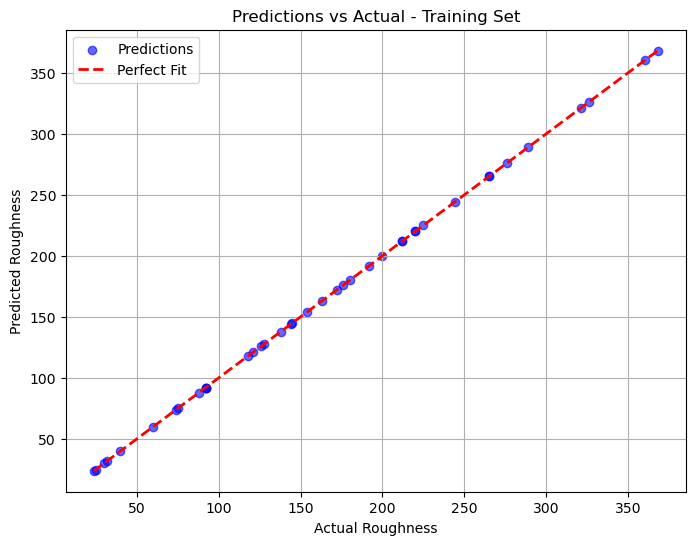

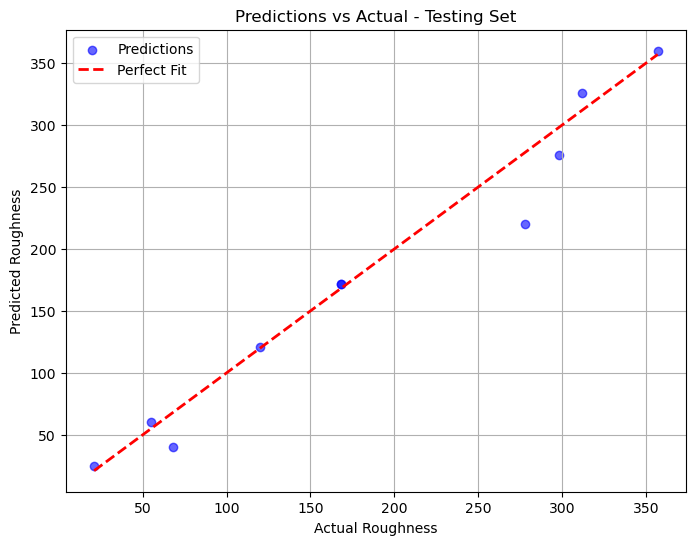

In [22]:
#Plot predictions
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Fit')
    plt.xlabel("Actual Roughness")
    plt.ylabel("Predicted Roughness")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_predictions(y_train, y_train_pred, "Predictions vs Actual - Training Set")
plot_predictions(y_test, y_test_pred, "Predictions vs Actual - Testing Set")

The structure of the trained decision tree is visualized to understand decision-making at each node.

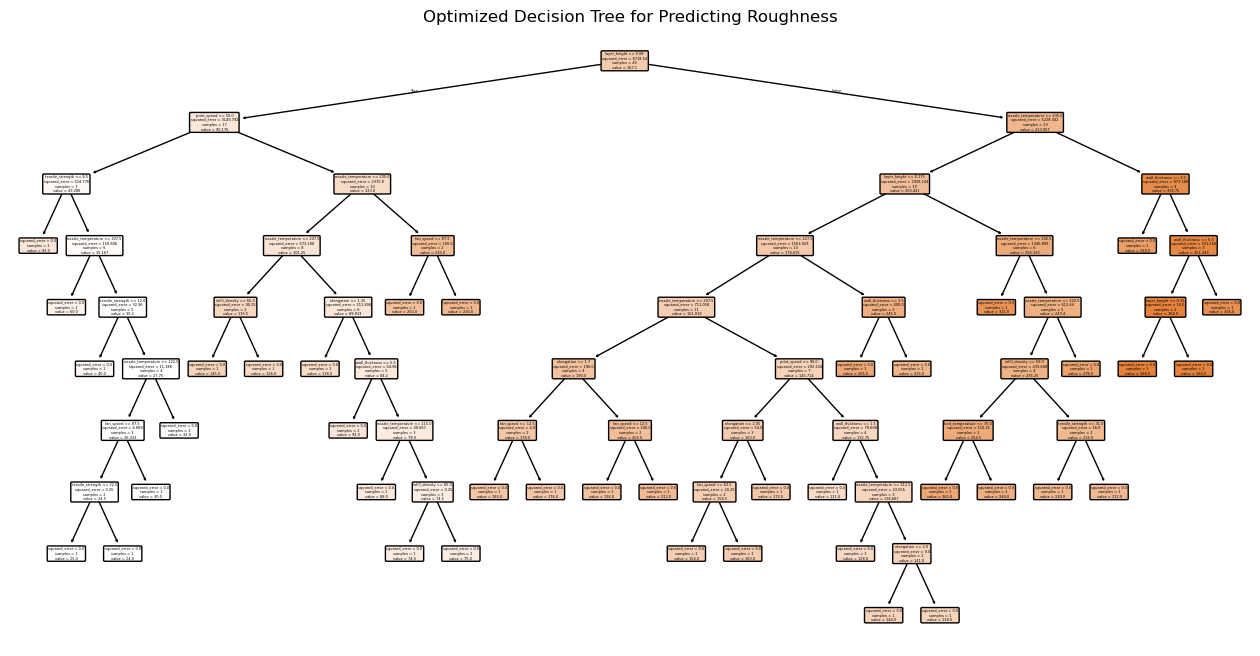

In [24]:
#Plot decision tree
plt.figure(figsize=(16, 8))
plot_tree(final_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Optimized Decision Tree for Predicting Roughness")
plt.show()

This heatmap shows how model performance varies across different combinations of `max_depth` and `random_state`.

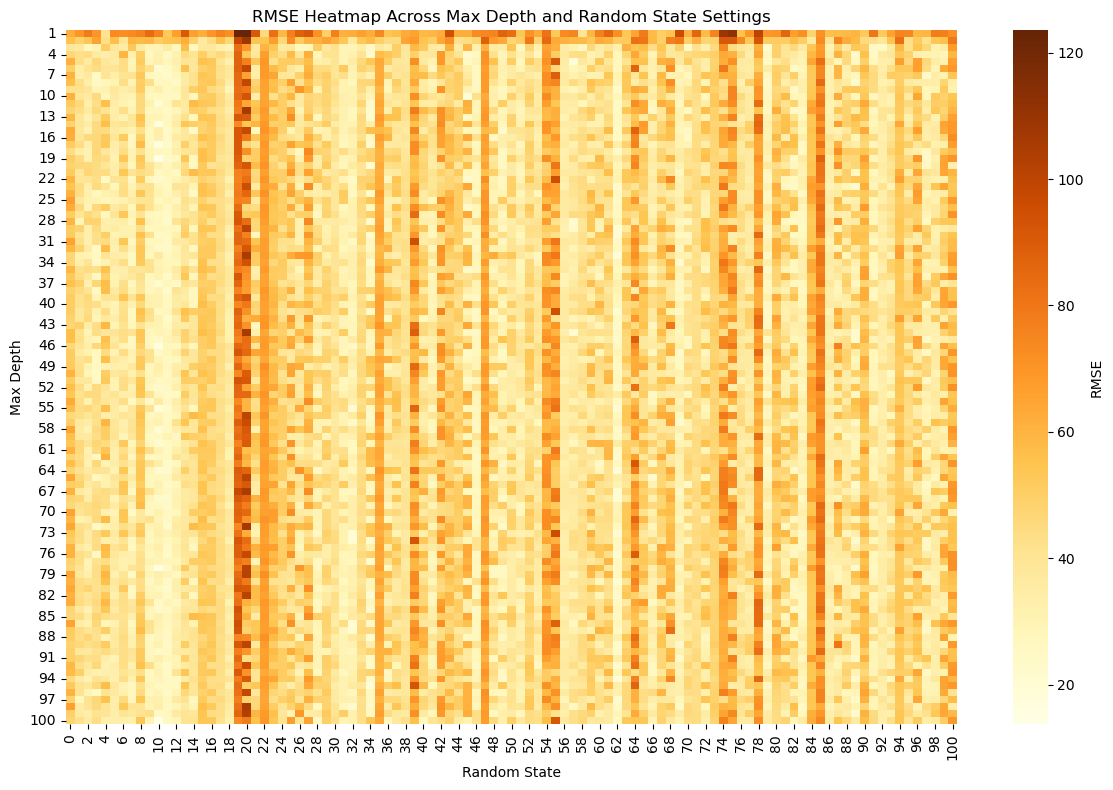

In [26]:
#RMSE Heatmap
pivot_rmse = results_df.pivot(index='MaxDepth', columns='RandomState', values='RMSE')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_rmse, cmap="YlOrBr", cbar_kws={'label': 'RMSE'})
plt.title("RMSE Heatmap Across Max Depth and Random State Settings")
plt.xlabel("Random State")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

We repeat the training and evaluation across a range of depths to analyze consistency and robustness.

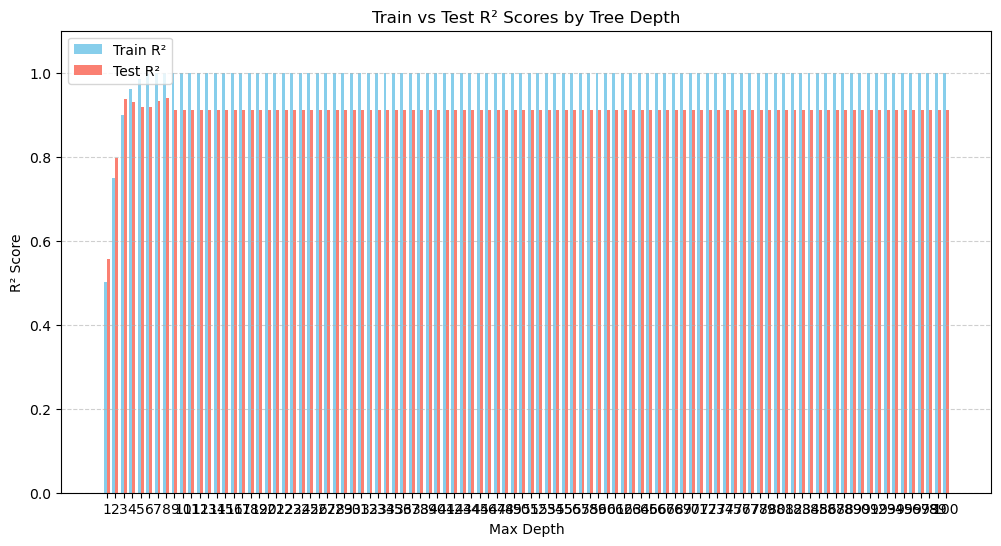

In [28]:
#Define range of depths to test
depths = range(1, 101)
r2_train_scores = []
r2_test_scores = []

#Train and collect R² scores
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=int(best_model['RandomState']))
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

#Bar chart visualization
x = np.arange(len(depths))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_train_scores, width, label='Train R²', color='skyblue')
plt.bar(x + width/2, r2_test_scores, width, label='Test R²', color='salmon')

plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Train vs Test R² Scores by Tree Depth')
plt.xticks(x, depths)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

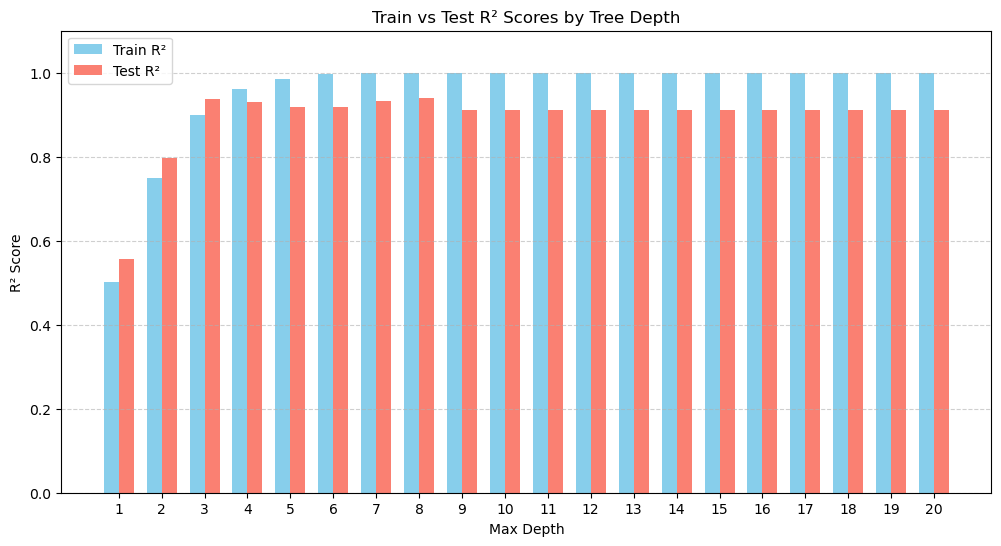

In [29]:
#Define range of depths to test
depths = range(1, 21)
r2_train_scores = []
r2_test_scores = []

#Train and collect R² scores
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=int(best_model['RandomState']))
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

#Bar chart visualization
x = np.arange(len(depths))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_train_scores, width, label='Train R²', color='skyblue')
plt.bar(x + width/2, r2_test_scores, width, label='Test R²', color='salmon')

plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Train vs Test R² Scores by Tree Depth')
plt.xticks(x, depths)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

The bar chart presents the performance of a Decision Tree Regressor across varying tree depths from 1 to 100, showing both training and testing R² scores. By depth 9, the training R² reaches the maximum score of 1.00, indicating a perfect fit to the training data. 

However, it is difficult to read the graph. Hence, depths from 1 to 20 has been chosen since approximately this point test R2 remains unchanged.

The training R² score begins relatively low at a tree depth of 1 and rises quickly with increasing depth. 

The test R² score shows a different pattern. It increases steadily until around depth 5 or 6, where it reaches its peak. After that point, the test R² score either plateaus or slightly decreases, remaining relatively high but showing no further gains in performance. This suggests that additional model complexity beyond a certain depth does not yield any improvement on the test data and may even slightly harm generalization due to overfitting.

In summary, the optimal tree depth appears to be in the range of 3 to 4, where the model achieves a good balance between fitting the training data and maintaining strong predictive performance on the test set. Depths beyond this range do not enhance the model's accuracy and instead contribute to overfitting, and depths before that signal to underfitting.

The best Max Depths is 4 since it has the lowest difference between train and test R^2 without overfitting. The model is the best fit for the data most accurately modelling it, and increasing its predictive power.

The final model is trained again using the best `random_state` identified earlier for more focused evaluation.

In [32]:
#Use the best random_state identified earlier
best_random_state = int(best_model['RandomState'])

#Train model with max_depth = 4
model_depth_4 = DecisionTreeRegressor(max_depth=4, random_state=best_random_state)
model_depth_4.fit(X_train, y_train)

#Make predictions
y_train_pred = model_depth_4.predict(X_train)
y_test_pred = model_depth_4.predict(X_test)

#Calculate R²
r2_train_depth_4 = r2_score(y_train, y_train_pred)
r2_test_depth_4 = r2_score(y_test, y_test_pred)

#Calculate MAE and RMSE
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

#Display results
print(f"Train R² (Depth 4): {r2_train_depth_4:.4f}")
print(f"Test R²  (Depth 4): {r2_test_depth_4:.4f}")
print(f"Train MAE         : {mae_train:.4f}")
print(f"Test MAE          : {mae_test:.4f}")
print(f"Train RMSE        : {rmse_train:.4f}")
print(f"Test RMSE         : {rmse_test:.4f}")


Train R² (Depth 4): 0.9618
Test R²  (Depth 4): 0.9308
Train MAE         : 12.8245
Test MAE          : 25.2182
Train RMSE        : 18.2613
Test RMSE         : 29.9342


The above evaluation parameters can be seen for the best optimised model for the roughness target. The model of depth 4 shows strong correlation R^2 for both of the sets indicating that the chosen model is robust for the data predicion. As previously stated the best tree model for the roughness parameter is 4 drpth and with the best random state of 10. 